# Description 

In this project, we addressed the task of identifying and classifying dataset citations in scientific articles as either Primary or Secondary. We began by loading the training labels and removing entries with missing dataset references. Then, we filtered the dataset to include only those articles with available XML files, from which we extracted the full article text by parsing <p> tags using Python’s XML utilities. After cleaning the data and ensuring proper text extraction, we performed exploratory data analysis to understand text lengths and label distribution.

We discovered a class imbalance, with Secondary citations significantly outnumbering Primary ones. To resolve this, we oversampled the underrepresented Primary class, creating a balanced dataset. A train-validation split was then performed to enable local model evaluation. Our next step involves training a transformer-based NLP model—such as SciBERT—fine-tuned on the labeled text data, to classify citation types based on the full article context. This setup prepares us to effectively tackle the citation classification challenge using state-of-the-art language modeling techniques.

# Import Module

In [1]:
import pandas as pd
import os
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Processing data

In [2]:
# ==== Step 1: Load Label ====
labels_df = pd.read_csv('/kaggle/input/make-data-count-finding-data-references/train_labels.csv')

# Ambil hanya yang tidak 'Missing'
labels_df = labels_df[labels_df['dataset_id'] != 'Missing'].copy()
print("Total berlabel (bukan 'Missing'):", len(labels_df))


Total berlabel (bukan 'Missing'): 719


In [3]:
# ==== Step 2: Ambil semua file XML yang tersedia ====
xml_dir = '/kaggle/input/make-data-count-finding-data-references/train/XML/'
xml_files = glob.glob(os.path.join(xml_dir, '*.xml'))

# Buat set nama file (tanpa .xml)
available_article_ids = set(os.path.basename(f).replace('.xml', '') for f in xml_files)
print("Total file XML tersedia:", len(available_article_ids))


Total file XML tersedia: 400


In [4]:
# ==== Step 3: Filter label yang ada file-nya ====
labels_df = labels_df[labels_df['article_id'].isin(available_article_ids)].copy()
print("Setelah cocok dengan file XML:", len(labels_df))

Setelah cocok dengan file XML: 645


In [5]:
# ==== Step 4: Normalisasi dataset_id ====
def normalize_dataset_id(ds):
    ds = str(ds).strip()
    if ds.lower().startswith('doi:'):
        ds = ds[4:]
    if ds.lower().startswith('http://dx.doi.org/'):
        ds = ds.replace('http://dx.doi.org/', '')
    if ds.lower().startswith('doi.org/'):
        ds = ds.replace('doi.org/', '')
    if not ds.lower().startswith('https://doi.org/'):
        return 'https://doi.org/' + ds
    return ds

labels_df['dataset_id'] = labels_df['dataset_id'].apply(normalize_dataset_id)


In [6]:
# ==== Step 5: Fungsi ekstraksi teks lengkap dari XML (paragraf, tail, title, abstract) ====
def extract_article_text(article_id, base_path=xml_dir):
    file_path = os.path.join(base_path, f"{article_id}.xml")

    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        paragraphs = []

        # Ambil teks dari <p> dan tail-nya
        for elem in root.iter():
            if elem.tag == 'p':
                if elem.text:
                    paragraphs.append(elem.text.strip())
                for child in elem:
                    if child.tail:
                        paragraphs.append(child.tail.strip())

        # Ambil judul
        title = ''
        title_elem = root.find(".//title-group/article-title")
        if title_elem is not None and title_elem.text:
            title = title_elem.text.strip()

        # Ambil abstrak
        abstract = ''
        abstract_elem = root.find(".//abstract")
        if abstract_elem is not None:
            abstract = ''.join(abstract_elem.itertext()).strip()

        full_text = "\n".join([title, abstract] + paragraphs)
        return full_text

    except Exception as e:
        print(f"Gagal memproses {article_id}: {e}")
        return ""


In [7]:
# ==== Step 6: Ambil teks semua artikel ====
labels_df['text'] = labels_df['article_id'].apply(extract_article_text)

In [8]:
# ==== Step 7: (Opsional) Tandai apakah dataset_id muncul dalam teks ====
labels_df['dataset_in_text'] = labels_df.apply(
    lambda row: row['dataset_id'].lower() in row['text'].lower(), axis=1
)

# Save Data labels

In [9]:
# ==== Step 8: Simpan ke file CSV ====
labels_df.to_csv("/kaggle/working/processed_train_labeled.csv", index=False)
print("✅ Data berhasil disimpan ke processed_train_labeled.csv")

✅ Data berhasil disimpan ke processed_train_labeled.csv


In [10]:
# ==== Step 9: Preview ====
labels_df[['article_id', 'dataset_id', 'type', 'dataset_in_text', 'text']].head(10)

,article_id,dataset_id,type,dataset_in_text,text
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,False,\n
11,10.1002_ece3.4466,https://doi.org/10.5061/dryad.r6nq870,Primary,False,Incubation temperature and parental identity d...
12,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary,False,Ultraconserved element (UCE) probe set design:...
14,10.1002_ece3.6144,https://doi.org/10.5061/dryad.zw3r22854,Primary,False,Efficacy of metabarcoding for identification o...
15,10.1002_ece3.6303,https://doi.org/10.5061/dryad.37pvmcvgb,Primary,False,Can polyploidy confer invasive plants with a w...
18,10.1002_ece3.9627,https://doi.org/10.5061/dryad.b8gtht7h3,Primary,False,Inferring predator–prey interactions from came...
20,10.1002_ecs2.4619,https://doi.org/10.25349/d9qw5x,Primary,False,\n
25,10.1002_esp.5090,https://doi.org/10.5066/p9353101,Secondary,False,\n
26,10.1002_mp.14424,https://doi.org/10.7937/k9/tcia.2015.pf0m9rei,Secondary,False,PleThora: Pleural effusion and thoracic cavity...
27,10.1002_mp.14424,https://doi.org/10.7937/tcia.2020.6c7y-gq39,Primary,False,PleThora: Pleural effusion and thoracic cavity...


# Explatory data Analysis

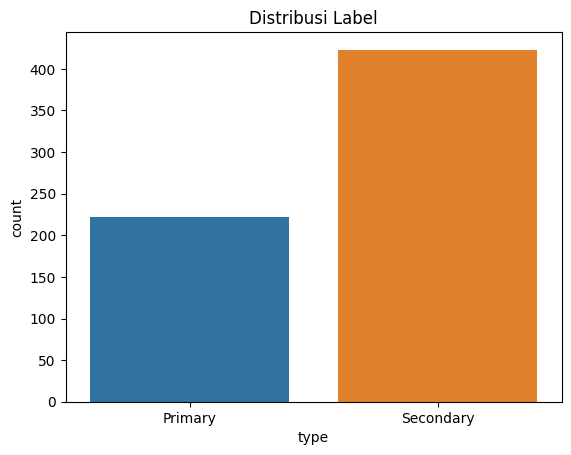

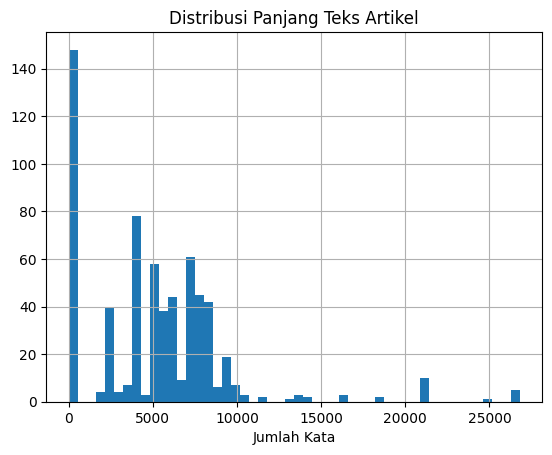

In [11]:
sns.countplot(data=labels_df, x='type')
plt.title("Distribusi Label")
plt.show()

# Panjang teks artikel
labels_df['text_length'] = labels_df['text'].apply(lambda x: len(x.split()))
labels_df['text_length'].hist(bins=50)
plt.title("Distribusi Panjang Teks Artikel")
plt.xlabel("Jumlah Kata")
plt.show()


In [12]:
labels_df['text_length'] = labels_df['text'].apply(lambda x: len(x.strip().split()))
print("Jumlah artikel dengan teks kosong:", (labels_df['text_length'] == 0).sum())


Jumlah artikel dengan teks kosong: 148


In [13]:

def extract_article_text_bs(article_id, base_path=xml_dir):
    file_path = os.path.join(base_path, f"{article_id}.xml")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            xml = f.read()
            soup = BeautifulSoup(xml, 'xml')
            # Ambil semua teks dari <p> tag
            paragraphs = [p.get_text(strip=True) for p in soup.find_all('p')]
            return "\n".join(paragraphs)
    except Exception as e:
        print(f"Gagal memproses {article_id}: {e}")
        return ""


In [14]:
labels_df['text'] = labels_df['article_id'].apply(extract_article_text_bs)
labels_df['text_length'] = labels_df['text'].apply(lambda x: len(x.strip().split()))
print("Jumlah artikel dengan teks kosong setelah parsing ulang:", (labels_df['text_length'] == 0).sum())


Jumlah artikel dengan teks kosong setelah parsing ulang: 24


<Axes: title={'center': 'Distribusi Label (Primary vs Secondary)'}, xlabel='type'>

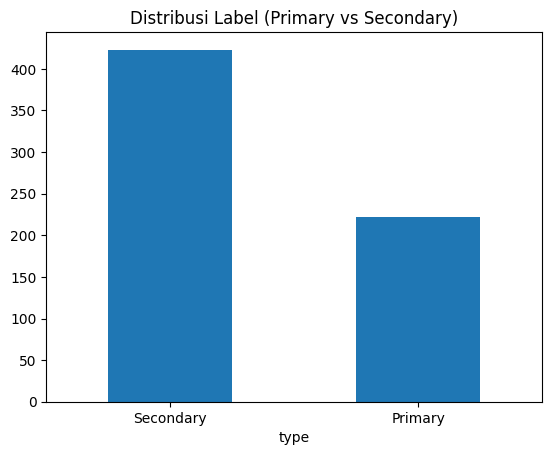

In [15]:
labels_df['type'].value_counts().plot(kind='bar', title="Distribusi Label (Primary vs Secondary)", rot=0)

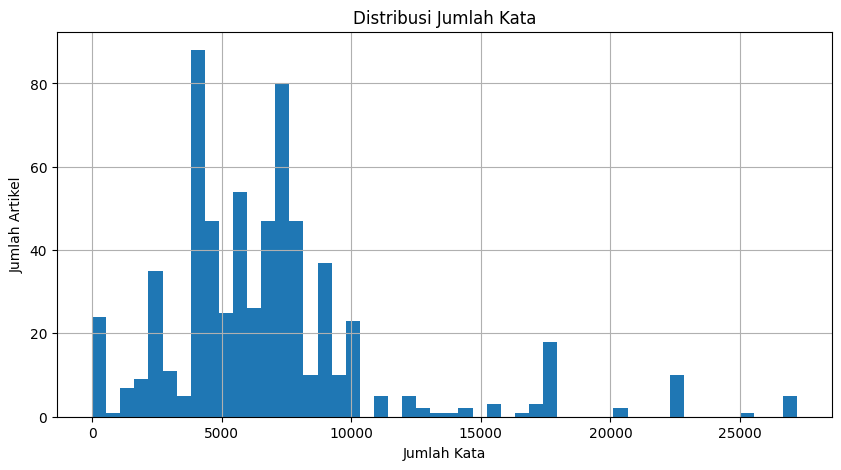

In [16]:
import matplotlib.pyplot as plt

labels_df['word_count'] = labels_df['text'].apply(lambda x: len(x.strip().split()))
labels_df['word_count'].hist(bins=50, figsize=(10, 5))
plt.title("Distribusi Jumlah Kata")
plt.xlabel("Jumlah Kata")
plt.ylabel("Jumlah Artikel")
plt.grid(True)
plt.show()


In [17]:
print("Contoh teks pendek:")
print(labels_df.sort_values('word_count').iloc[0]['text'])

print("\nContoh teks panjang:")
print(labels_df.sort_values('word_count', ascending=False).iloc[0]['text'][:1000])  # max 1000 char


Contoh teks pendek:


Contoh teks panjang:
These authors contributed equally to this work.
Bioinformatics and Data Science, Research and Early Development, Oncology R&D, AstraZeneca, Cambridge, United Kingdom.
Data Science & Artificial Intelligence, Imaging & Data Analytics, Clinical Pharmacology & Safety Sciences, R&D, AstraZeneca, Gothenburg, Sweden.
Prostate cancer is the second most occurring cancer in men worldwide. To better understand the mechanisms of tumorigenesis and possible treatment responses, we developed a mathematical model of prostate cancer which considers the major signalling pathways known to be deregulated. We personalised this Boolean model to molecular data to reflect the heterogeneity and specific response to perturbations of cancer patients. A total of 488 prostate samples were used to build patient-specific models and compared to available clinical data. Additionally, eight prostate cell line-specific models were built to validate our approach with dose-respon

In [18]:
labels_df['word_count'].describe()

count      645.000000
mean      6816.348837
std       4451.802377
min          0.000000
25%       4040.000000
50%       6138.000000
75%       7765.000000
max      27188.000000
Name: word_count, dtype: float64

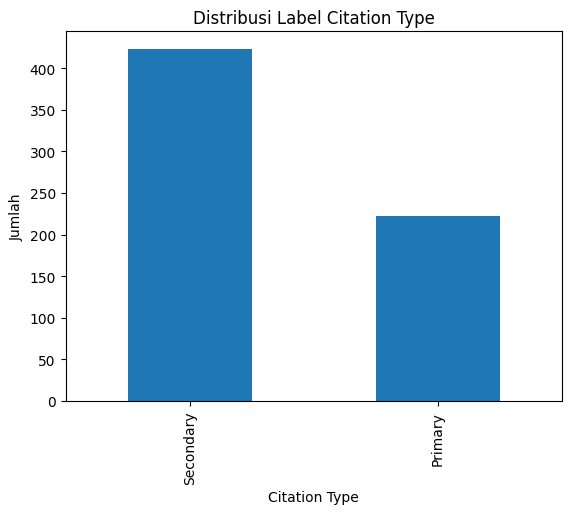

In [19]:
labels_df['type'].value_counts().plot(kind='bar', title="Distribusi Label Citation Type")
plt.xlabel("Citation Type")
plt.ylabel("Jumlah")
plt.show()

In [20]:
# Misal: class 'Primary' underrepresented
primary_df = labels_df[labels_df['type'] == 'Primary']
secondary_df = labels_df[labels_df['type'] == 'Secondary']

# Oversample Primary secara manual
primary_oversampled = primary_df.sample(len(secondary_df), replace=True, random_state=42)

# Gabung jadi dataset seimbang
balanced_df = pd.concat([secondary_df, primary_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)


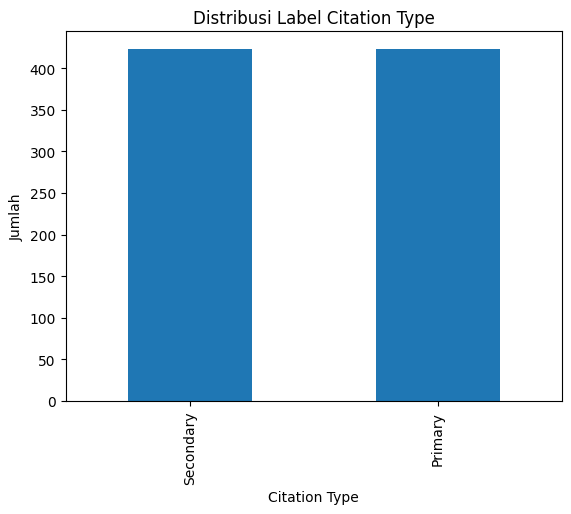

In [21]:
balanced_df['type'].value_counts().plot(kind='bar', title="Distribusi Label Citation Type")
plt.xlabel("Citation Type")
plt.ylabel("Jumlah")
plt.show()

During the exploratory data analysis (EDA) stage, we identified several key insights related to data quality and distribution. Initially, we discovered that 148 articles had empty text content after XML parsing. Upon reprocessing using a more robust parsing method, this number was reduced to 24. This highlighted inconsistencies in the XML structure across articles, emphasizing the need for flexible parsing techniques to ensure text extraction is as complete and accurate as possible.

Additionally, we observed a significant class imbalance in the citation type labels — the Secondary class appeared far more frequently than Primary. This imbalance posed a risk of model bias toward the majority class during training. To address this, we applied oversampling to the Primary class to equalize the number of samples from both classes. Balancing the dataset ensures that the classifier can learn representative features for both citation types, improving overall performance and fairness.

#  Preprocessing Teks and Vectorizer

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

balanced_df['clean_text'] = balanced_df['text'].fillna('').apply(clean_text)

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(balanced_df['clean_text'])
y = balanced_df['type']

# Simpan vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [23]:
# 1. Bentuk matriks hasil vektorisasi
print("TF-IDF matrix shape:", X.shape)  # (jumlah dokumen, jumlah fitur)

# 2. Konversi ke array agar bisa dilihat nilai-nilainya
X_dense = X.todense()

# 3. Lihat beberapa baris pertama
print("\nContoh representasi TF-IDF (5 dokumen pertama):")
print(X_dense[:5])

# 4. Tampilkan beberapa fitur kata yang digunakan
print("\nFitur (kata/ngram) yang dipakai:")
print(tfidf.get_feature_names_out()[:20])  # 20 fitur pertama


TF-IDF matrix shape: (846, 10000)

Contoh representasi TF-IDF (5 dokumen pertama):
[[0.         0.00304524 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00232796 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Fitur (kata/ngram) yang dipakai:
['aa' 'ab' 'aba' 'abbreviated' 'abbreviated as' 'abc' 'ability'
 'ability of' 'ability to' 'abiotic' 'able' 'able to' 'abnormal' 'about'
 'about the' 'above' 'above and' 'above the' 'above we' 'aboveground']


# Modelling


🔍 Model: Logistic Regression
              precision    recall  f1-score   support

     Primary       0.91      0.95      0.93        85
   Secondary       0.95      0.91      0.93        85

    accuracy                           0.93       170
   macro avg       0.93      0.93      0.93       170
weighted avg       0.93      0.93      0.93       170



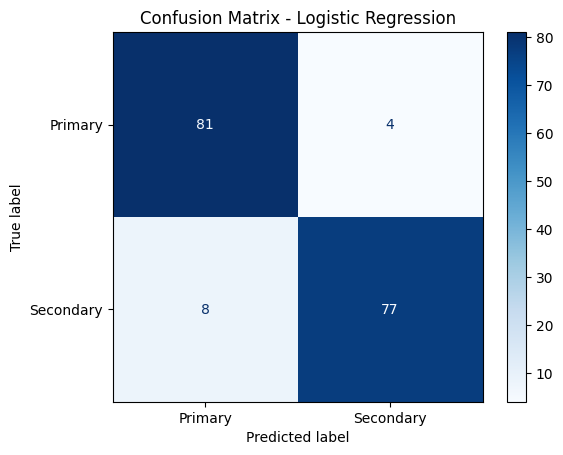


🔍 Model: Naive Bayes
              precision    recall  f1-score   support

     Primary       0.87      0.93      0.90        85
   Secondary       0.92      0.86      0.89        85

    accuracy                           0.89       170
   macro avg       0.90      0.89      0.89       170
weighted avg       0.90      0.89      0.89       170



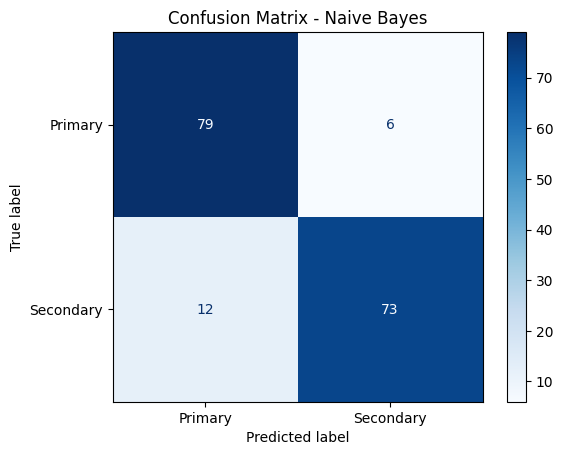


🔍 Model: Linear SVC
              precision    recall  f1-score   support

     Primary       0.96      0.94      0.95        85
   Secondary       0.94      0.96      0.95        85

    accuracy                           0.95       170
   macro avg       0.95      0.95      0.95       170
weighted avg       0.95      0.95      0.95       170



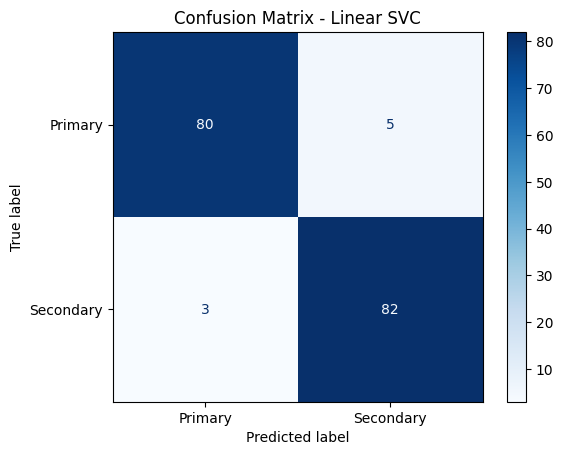


🔍 Model: Random Forest
              precision    recall  f1-score   support

     Primary       0.95      0.94      0.95        85
   Secondary       0.94      0.95      0.95        85

    accuracy                           0.95       170
   macro avg       0.95      0.95      0.95       170
weighted avg       0.95      0.95      0.95       170



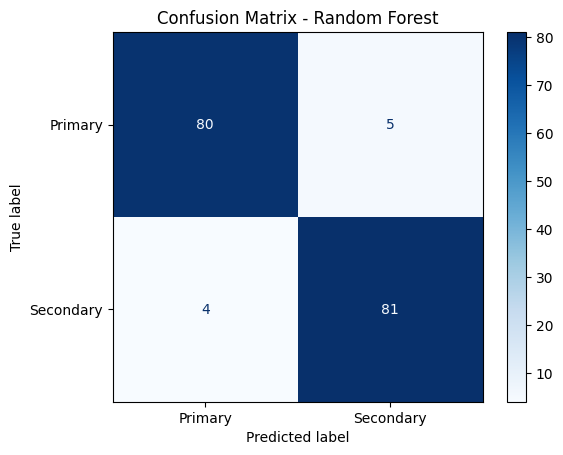


🔍 Model: XGBoost
              precision    recall  f1-score   support

     Primary       0.96      0.94      0.95        85
   Secondary       0.94      0.96      0.95        85

    accuracy                           0.95       170
   macro avg       0.95      0.95      0.95       170
weighted avg       0.95      0.95      0.95       170



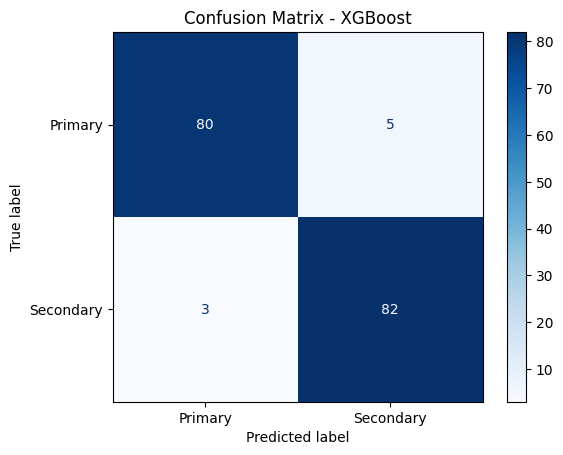


💾 Menyimpan model terbaik: Linear SVC (Accuracy: 0.9529)


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib  # ✅ untuk menyimpan model dan vectorizer

# Encode y menjadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'Primary' -> 0, 'Secondary' -> 1

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Daftar model
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

best_model = None
best_score = 0

# Evaluasi model
for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Classification report
    print(classification_report(le.inverse_transform(y_val), le.inverse_transform(y_pred)))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Simpan model terbaik berdasarkan akurasi
    score = model.score(X_val, y_val)
    if score > best_score:
        best_score = score
        best_model = model
        best_model_name = name

# ✅ Simpan model terbaik, tfidf vectorizer, dan label encoder
if best_model is not None:
    print(f"\n💾 Menyimpan model terbaik: {best_model_name} (Accuracy: {best_score:.4f})")
    joblib.dump(best_model, 'best_model.pkl')
    joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
    joblib.dump(le, 'label_encoder.pkl')


# Predicting on Test Data

In [25]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import re
import joblib

# Load kembali vectorizer, model, dan encoder
tfidf = joblib.load('/kaggle/working/tfidf_vectorizer.pkl')
model = joblib.load('/kaggle/working/best_model.pkl')
le = joblib.load('/kaggle/working/label_encoder.pkl')

# Ambil semua XML test
test_dir = '/kaggle/input/make-data-count-finding-data-references/test/XML/'
test_files = glob.glob(os.path.join(test_dir, '*.xml'))
test_ids = [os.path.basename(f).replace('.xml', '') for f in test_files]

def extract_article_text(article_id, base_path=test_dir):
    file_path = os.path.join(base_path, f"{article_id}.xml")
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        paragraphs = [elem.text.strip() for elem in root.iter() if elem.tag == 'p' and elem.text]
        return "\n".join(paragraphs)
    except:
        return ""

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

# Proses test data
test_df = pd.DataFrame({'article_id': test_ids})
test_df['text'] = test_df['article_id'].apply(extract_article_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Transform dan prediksi
X_test = tfidf.transform(test_df['clean_text'])
y_test_pred = model.predict(X_test)

# Konversi label
predicted_labels = le.inverse_transform(y_test_pred)
test_df['predicted_type'] = predicted_labels

# Simpan sebagai submission
test_df[['article_id', 'predicted_type']].to_csv('/kaggle/working/submission.csv', index=False)


Summary of the Modeling Workflow
In this project, we developed a text classification model to identify whether a scientific article references a dataset as a Primary or Secondary citation. We began by exploring the labeled training data, where we found that the class distribution was imbalanced, with significantly more Secondary citations. To address this, we applied oversampling on the Primary class to create a balanced dataset. The text data from XML files was extracted and cleaned by lowercasing and removing punctuation. Then, we used TF-IDF vectorization with unigram and bigram features to convert the cleaned text into numerical form suitable for modeling.

After transforming the data, we trained and evaluated multiple machine learning models including Logistic Regression, Naive Bayes, Linear SVC, Random Forest, and XGBoost. The best-performing models achieved F1-scores above 0.93 on the validation set. Finally, we applied the trained model to the official unlabeled test set provided by the competition organizers, processed the XML files, and predicted the citation types for each article. The predictions were saved and are ready for submission or further analysis.